In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from string import punctuation

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
stop_words = stopwords.words('English')

pd.set_option('display.max_colwidth', -1)

<ipython-input-1-82efa447308f>:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
def clean_text(s):
    if s[-1] == '.': 
        s = s[:-1]
    return s.lower().replace('\n', ' ')

In [3]:
headers = ["Allegation ID", "Section Name", "Column Name", "Text Content", "Area Name", "Median Income", "Complainant Gender", "Complainant Race", "Complainant Birth Year"]

raw_data = pd.read_csv('./data/community_allegation_narratives.csv', 
    names=headers
)

# Removing lines without meaningful summaries
data = raw_data[~raw_data['Text Content'].isin([
    '(None Entered)',
    'NOMISCONDUCT\n(NOTIF)',
    'NOT SUSTAINED'
])]
data['Text Content'] = data['Text Content'].apply(lambda x: clean_text(x))
data = data.drop_duplicates(subset=['Text Content'])

<ipython-input-3-6ed7420e8e0f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Text Content'] = data['Text Content'].apply(lambda x: clean_text(x))


In [4]:
data.columns

Index(['Allegation ID', 'Section Name', 'Column Name', 'Text Content',
       'Area Name', 'Median Income', 'Complainant Gender', 'Complainant Race',
       'Complainant Birth Year'],
      dtype='object')

In [5]:
summaries = data['Text Content']

In [6]:
data

,Allegation ID,Section Name,Column Name,Text Content,Area Name,Median Income,Complainant Gender,Complainant Race,Complainant Birth Year
0,1062924,Accused Members,Initial / Intake Allegation,the complainant stated that she was involved in traffic accident with another ewvillan the complainant alleged that the accused officer incorrectly and inacurrately completed the traffic crash accident report the complainant did not have her case report number,Hermosa,"$39,057",F,Hispanic,1971.0
1,1050875,Accused Members,Initial / Intake Allegation,"the complainant alleges that the accused failed to arrest a female offender who threw a bottle at her and refused to leave the premises, the complainant alleges that the accused failed to arrest a female offender who threw a bottle at her and refused to leave the premises",Chicago Lawn,"$32,944",F,Black,1977.0
3,1060347,Accused Members,Initial / Intake Allegation,"and that she was afraid that the might come back. the reporting alleges that the accused was rude and and stated in an aggressive ""maybe we can look at the tape. if so scared, change your locks. i'm not to do anything for you.”",North Park,"$51,589",F,White,1970.0
4,1060347,Accused Members,Initial / Intake Allegation,"the reporting party alleges that she called to speak to the accused, who is assigned to investigate her case. the reporting party alleges that she stated to the accused that the offender had all of her information and keys to her place of residence and that she was afraid that the offender might come back. the reporting party alleges that the accused was rude and unprofessional and stated in an aggressive manner, ""maybe we can look at the tape. if you're so scared, change your locks. i'm not going to do anything for you.”",North Park,"$51,589",F,White,1970.0
5,1049777,Accused Members,Initial / Intake Allegation,the reporting party alleges that the accused officer had his vehicle illegally towed due to loud music. the reporting party alleges that the speakers in his vehicle are not operating therefore; the impounding of his vehicle was just harassment from the accused officer,Chicago Lawn,"$32,944",M,Black,1989.0
...,...,...,...,...,...,...,...,...,...
47699,1063984,Accused Members,Initial / Intake Allegation,"the complainant alleged that the accused officer refused to properly investigate the victim's report of a “road rage"" altercation with another driver",North Park,"$51,589",M,Hispanic,1988.0
47704,1049236,Accused Members,Initial / Intake Allegation,"the reporting party, who is representing himself, alleges that the accused struck him with a squad car, which caused serveral bruises on his face, legs, knees and back. the reporting party further alleges that while he was on the ground, the accused stepped on his back, handcuffed him and then threw him in the backseat of the squad car",Greater Grand Crossing,"$26,354",M,Black,1980.0
47708,1051081,Accused Members,Initial / Intake Allegation,"the reporting party alleges that the accused officer was rude and unprofessional in that the accused officer called the victim to clear a missing person and the victim stated that he would have to wait until he was available to serve him. the accused officer responded, ""l don't want to hear that shit you fucking jag off.""",Douglas,"$29,099",M,Black,1964.0
47710,1051081,Current Allegations,Allegation,"the complainant, police officer gregory rudolph #16639, unit 184 alleges that on 03 january 2012 at 2255 hours, via the telephone detective joseph mc guire #20016, unit 620 was rude and unprofessional the complainant, police officer gregory rudolph #16639, unit 184 further alleegs that on 04 january 2012 at 1745 hours, via the telephone detective joseph mc guire #20016, unit 620 threatened him and denied his request to speak to a supervisor",Douglas,"$29,099",M,Black,1964.0


# Area vs Income

In [7]:
# Find all compound sentiment scores, divided by area
area_scores = {}
for n, (area, text, income) in enumerate(zip(data['Area Name'], data['Text Content'], data['Median Income'])):
    clean = clean_text(text)
    
    if area not in area_scores:
        area_scores[area] = {
            'total_score': 0,
            'count': 0,
            'income': income
        }
    
    scores = sid.polarity_scores(clean)
    
    area_scores[area]['count'] += 1
    area_scores[area]['total_score'] += scores['compound']

In [8]:
sorted_scores = sorted([
    (
        area, 
        area_scores[area]['total_score'] / area_scores[area]['count'],
        area_scores[area]['income']
    )
    for area in area_scores
], key=lambda line: line[1])

In [9]:
pd.DataFrame(sorted_scores, columns=['Area', 'Score', 'Income'], )

,Area,Score,Income
0,Edison Park,-0.599305,"$84,331"
1,Jefferson Park,-0.597945,"$60,384"
2,Lincoln Square,-0.589593,"$62,427"
3,South Lawndale,-0.573953,"$30,603"
4,Hegewisch,-0.565878,"$50,252"
...,...,...,...
72,O'Hare,-0.420273,"$46,065"
73,Oakland,-0.407486,"$28,269"
74,Portage Park,-0.395742,"$56,649"
75,Edgewater,-0.394468,"$46,103"


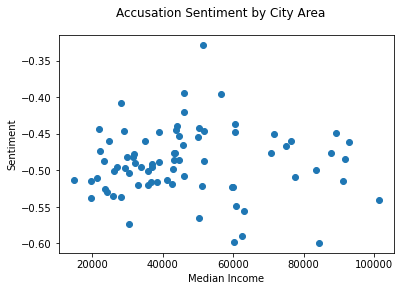

In [10]:
plot_x = [int(x[2][1:].replace(',', '')) for x in sorted_scores]
plot_y = [y[1] for y in sorted_scores]

plt.suptitle('Accusation Sentiment by City Area')
plt.xlabel('Median Income')
plt.ylabel('Sentiment')
plt.scatter(plot_x, plot_y)

# Race

In [11]:
race_scores = {}
for race, text in zip(data['Complainant Race'], data['Text Content']):
    clean = clean_text(text)
    if race == 'Native American/Alaskan Native':
        # Not enough examples to confidently include
        continue
    elif race == 'Asian/Pacific Islander':
        race = 'Asian'
    
    if race not in race_scores:
        race_scores[race] = {
            'total_score': 0,
            'count': 0
        }
    
    scores = sid.polarity_scores(clean)
    
    race_scores[race]['count'] += 1
    race_scores[race]['total_score'] += scores['compound']

In [12]:
race_data = dict(sorted([
    (race, -1 * race_scores[race]['total_score'] / race_scores[race]['count'])
    for race in race_scores if type(race) == str
], key=lambda item: item[1]))

<BarContainer object of 4 artists>

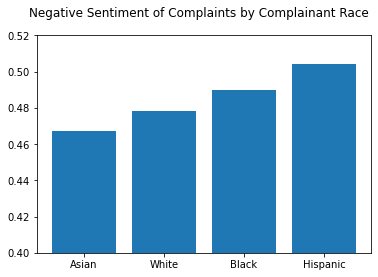

In [13]:
plt.suptitle('Negative Sentiment of Complaints by Complainant Race')
plt.ylim([0.4, 0.52])
plt.bar(race_data.keys(), [race_data[race] for race in race_data])

In [14]:
pd.DataFrame(race_data.items(), columns=['Race', 'Avg Score'])

,Race,Avg Score
0,Asian,0.467126
1,White,0.478442
2,Black,0.489578
3,Hispanic,0.503951


# Race and Gender

In [15]:
race_gender_scores = {}
for race, gender, text in zip(data['Complainant Race'], data['Complainant Gender'], data['Text Content']):
    clean = clean_text(text)
    if race == 'Native American/Alaskan Native':
        # Not enough examples to confidently include
        continue
    elif race == 'Asian/Pacific Islander':
        race = 'Asian'
    elif float in [type(race), type(gender)]:
        continue
        
    key = race + '_' + gender
    
    if key not in race_gender_scores:
        race_gender_scores[key] = {
            'total_score': 0,
            'count': 0
        }
    
    scores = sid.polarity_scores(clean)
    
    race_gender_scores[key]['count'] += 1
    race_gender_scores[key]['total_score'] += scores['compound']

In [16]:
race_gender_data = dict(sorted([
    (key, -1 * race_gender_scores[key]['total_score'] / race_gender_scores[key]['count'])
    for key in race_gender_scores if type(key) == str
], key=lambda item: item[1]))

<BarContainer object of 8 artists>

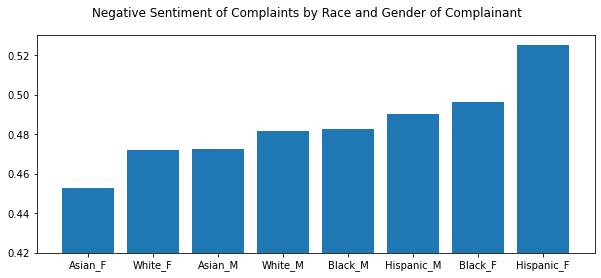

In [17]:
plt.figure(figsize=(10, 4))
plt.suptitle('Negative Sentiment of Complaints by Race and Gender of Complainant')
plt.ylim([0.42, 0.53])
plt.bar(race_gender_data.keys(), [race_gender_data[key] for key in race_gender_data])

In [18]:
pd.DataFrame(race_gender_data.items(), columns=['Race', 'Avg Score'])

,Race,Avg Score
0,Asian_F,0.453001
1,White_F,0.472198
2,Asian_M,0.472570
3,White_M,0.481604
4,Black_M,0.482587
5,Hispanic_M,0.490032
6,Black_F,0.496370
7,Hispanic_F,0.524962


In [26]:
# headers = ["Allegation ID", "Section Name", "Column Name", "Text Content", "Area Name", "Median Income", "Complainant Gender", "Complainant Race", "Complainant Birth Year"]

X = data.drop(columns=["Allegation ID", "Section Name", "Column Name", "Text Content"]) # These don't tell us much about the nature of the complaint, but are mostly used to organize data

X = pd.get_dummies(X, columns=["Area Name", "Complainant Gender", "Complainant Race"]) # These are the categorical variables that we need to one-hot encode for regression. Change this if you have a better implementation


X # Final feature vector for each allegation

,Median Income,Complainant Birth Year,Area Name_Albany Park,Area Name_Archer Heights,Area Name_Armour Square,Area Name_Ashburn,Area Name_Auburn Gresham,Area Name_Austin,Area Name_Avalon Park,Area Name_Avondale,...,Area Name_West Ridge,Area Name_West Town,Area Name_Woodlawn,Complainant Gender_F,Complainant Gender_M,Complainant Race_Asian/Pacific Islander,Complainant Race_Black,Complainant Race_Hispanic,Complainant Race_Native American/Alaskan Native,Complainant Race_White
0,"$39,057",1971.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,"$32,944",1977.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,"$51,589",1970.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,"$51,589",1970.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
5,"$32,944",1989.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47699,"$51,589",1988.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
47704,"$26,354",1980.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
47708,"$29,099",1964.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
47710,"$29,099",1964.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [33]:
y = list(data['Text Content'])
y = [sid.polarity_scores(txt) for txt in y]

In [34]:
y

[{'neg': 0.341, 'neu': 0.632, 'pos': 0.027, 'compound': -0.9169},
 {'neg': 0.508, 'neu': 0.492, 'pos': 0.0, 'compound': -0.975},
 {'neg': 0.209, 'neu': 0.791, 'pos': 0.0, 'compound': -0.8605},
 {'neg': 0.205, 'neu': 0.723, 'pos': 0.071, 'compound': -0.9208},
 {'neg': 0.154, 'neu': 0.741, 'pos': 0.105, 'compound': -0.3612},
 {'neg': 0.137, 'neu': 0.784, 'pos': 0.078, 'compound': -0.1027},
 {'neg': 0.281, 'neu': 0.719, 'pos': 0.0, 'compound': -0.7783},
 {'neg': 0.146, 'neu': 0.85, 'pos': 0.004, 'compound': -0.9974},
 {'neg': 0.154, 'neu': 0.838, 'pos': 0.007, 'compound': -0.9975},
 {'neg': 0.101, 'neu': 0.899, 'pos': 0.0, 'compound': -0.5267},
 {'neg': 0.272, 'neu': 0.66, 'pos': 0.069, 'compound': -0.7906},
 {'neg': 0.084, 'neu': 0.843, 'pos': 0.073, 'compound': -0.4588},
 {'neg': 0.289, 'neu': 0.711, 'pos': 0.0, 'compound': -0.6249},
 {'neg': 0.266, 'neu': 0.607, 'pos': 0.126, 'compound': -0.4588},
 {'neg': 0.225, 'neu': 0.775, 'pos': 0.0, 'compound': -0.4939},
 {'neg': 0.306, 'neu': 0.